In [1]:
import utils as utils
import pickle
from pyedflib import highlevel
import os
import numpy as np
import matplotlib.pyplot as plt
from data_preparation import Data

plt.rcParams.update(utils.get_plt_settings())
plt.rcParams.update({"legend.loc": 'lower right'})

save=True

In [2]:
# signals, signal_headers, header = highlevel.read_edf(utils.get_ecg_path(), 'ecg_23.EDF')

# plt.plot(signals[0][240000:250000])

In [3]:
if os.path.isfile(utils.get_data_object_path()):
    with open(utils.get_data_object_path(), 'rb') as file:
        data = pickle.load(file)
else:
    data = Data()
    with open(utils.get_data_object_path(), 'wb') as file:
        pickle.dump(data, file)
        file.flush()

In [4]:
for series in data.data_series.values():
    print("ID: ", series.patient_id)
    length = series.ecg.length/60/60
    print("ECG length: ", "%.2f" % length)
    length = series.bcg.length/60/60
    print("BCG length: ", "%.2f" % length)
    print("---")

ID:  27
ECG length:  22.85
BCG length:  23.29
---
ID:  26
ECG length:  23.47
BCG length:  7.50
---
ID:  09
ECG length:  18.65
BCG length:  18.44
---
ID:  35
ECG length:  9.41
BCG length:  24.17
---
ID:  08
ECG length:  13.59
BCG length:  14.69
---
ID:  22
ECG length:  21.38
BCG length:  22.75
---
ID:  36
ECG length:  22.60
BCG length:  23.74
---
ID:  23
ECG length:  21.80
BCG length:  10.47
---
ID:  13
ECG length:  23.06
BCG length:  5.91
---
ID:  11
ECG length:  24.22
BCG length:  23.27
---
ID:  05
ECG length:  21.96
BCG length:  23.30
---
ID:  28
ECG length:  22.59
BCG length:  22.36
---
ID:  14
ECG length:  22.34
BCG length:  22.10
---
ID:  16
ECG length:  22.17
BCG length:  22.39
---


In [5]:
patient_ecg = data.data_series['26'].ecg
hr_singles = np.zeros(shape=(3, int(np.trunc(patient_ecg.length))))
hr_fusion = np.zeros(shape=(1, int(np.trunc(patient_ecg.length))))
hr_lowest_std = np.zeros(shape=(1, int(np.trunc(patient_ecg.length))))

for i in range(0, (int(np.trunc(patient_ecg.length)) * patient_ecg.sample_rate), 1000):                  
    start = i
    start2 = i - 5000
    if start2 < 0:
        start2 = 0
    end = i + 10000
    end2 = end + 5000
    if end >= int(np.trunc(patient_ecg.length))*1000:
        break
    if end2 >= int(np.trunc(patient_ecg.length))*1000:
        end2 = int(np.trunc(patient_ecg.length))*1000 - 1
    curr_hr = []
    curr_hr2 = []
    curr_range2 = []
    curr_range = []
    for channel, r_peaks_single in enumerate(patient_ecg.r_peaks.transpose()):
        if channel == 0:
            continue
        indices = np.argwhere(np.logical_and(start <= r_peaks_single, r_peaks_single < end))
        interval_lengths = [r_peaks_single[indices[i]] - r_peaks_single[indices[i - 1]] for i in range(1, len(indices))]
        indices2 = np.argwhere(np.logical_and(start2 <= r_peaks_single, r_peaks_single < end2))
        interval_lengths2 = [r_peaks_single[indices2[i]] - r_peaks_single[indices2[i - 1]] for i in range(1, len(indices2))]
        if interval_lengths:
            c_range = np.max(interval_lengths) - np.min(interval_lengths)
            c_range2 = np.max(interval_lengths2) - np.min(interval_lengths2)
            hr_guess = np.median(interval_lengths) / 1000 * 60
            hr_guess2 = np.median(interval_lengths2) / 1000 * 60
            lower_threshold_count = 30 * (end - start) / (1000 * 60)
            upper_threshold_count = 200 * (end - start) / (1000 * 60)
            if 30 < hr_guess < 200 and lower_threshold_count < len(indices) < upper_threshold_count:
                curr_hr.append(hr_guess)
                curr_hr2.append(hr_guess2)
                curr_range2.append(c_range2)
                curr_range.append(c_range)
                hr_singles[channel-1, int(i/1000)] = hr_guess
        if hr_singles[channel-1, int(i/1000)] == 0:
            hr_singles[channel-1, int(i/1000)] = np.nan
    if curr_hr:
        id_min_range = np.argwhere(curr_range == np.min(curr_range))
        id_min_range2 = np.argwhere(curr_range2 == np.min(curr_range2))
        hr_2 = np.median(np.array(curr_hr2)[id_min_range2])
        id_min_diff = np.argwhere(np.abs(curr_hr - hr_2) == np.min(np.abs(curr_hr - hr_2)))
        hr_lowest_std[0, int(i/1000)] = np.median(np.array(curr_hr)[id_min_range])
        hr_fusion[0, int(i/1000)] = np.median(np.array(curr_hr)[id_min_diff])
    else:
        hr_lowest_std[0, int(i/1000)] = np.nan
        hr_fusion[0, int(i/1000)] = np.nan

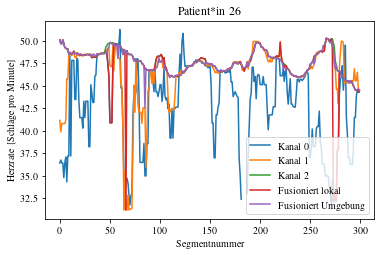

In [6]:
plt.figure(figsize=utils.get_plt_big_size())
for channel in range(3):
    plt.plot(hr_singles[channel, 30000:30300], label="Kanal " + str(channel))
plt.plot(hr_lowest_std[0, 30000:30300], label="Fusioniert lokal")
plt.plot(hr_fusion[0, 30000:30300], label="Fusioniert Umgebung")
plt.title("Patient*in 26")
plt.xlabel("Segmentnummer")
plt.ylabel("Herzrate [Schläge pro Minute]")
plt.legend()
if save:
    plt.savefig(os.path.join(utils.get_thesis_pic_path(),'ecg-patient-26.pdf'), transparent=True, bbox_inches='tight', dpi=300)

In [7]:
patient_ecg = data.data_series['35'].ecg
hr_singles = np.zeros(shape=(3, int(np.trunc(patient_ecg.length))))
hr_fusion = np.zeros(shape=(1, int(np.trunc(patient_ecg.length))))
hr_lowest_std = np.zeros(shape=(1, int(np.trunc(patient_ecg.length))))

for i in range(0, (int(np.trunc(patient_ecg.length)) * patient_ecg.sample_rate), 1000):                  
    start = i
    start2 = i - 5000
    if start2 < 0:
        start2 = 0
    end = i + 10000
    end2 = end + 5000
    if end >= int(np.trunc(patient_ecg.length))*1000:
        break
    if end2 >= int(np.trunc(patient_ecg.length))*1000:
        end2 = int(np.trunc(patient_ecg.length))*1000 - 1
    curr_hr = []
    curr_hr2 = []
    curr_range2 = []
    curr_range = []
    for channel, r_peaks_single in enumerate(patient_ecg.r_peaks.transpose()):
        if channel == 0:
            continue
        indices = np.argwhere(np.logical_and(start <= r_peaks_single, r_peaks_single < end))
        interval_lengths = [r_peaks_single[indices[i]] - r_peaks_single[indices[i - 1]] for i in range(1, len(indices))]
        indices2 = np.argwhere(np.logical_and(start2 <= r_peaks_single, r_peaks_single < end2))
        interval_lengths2 = [r_peaks_single[indices2[i]] - r_peaks_single[indices2[i - 1]] for i in range(1, len(indices2))]
        if interval_lengths:
            c_range = np.max(interval_lengths) - np.min(interval_lengths)
            c_range2 = np.max(interval_lengths2) - np.min(interval_lengths2)
            hr_guess = np.median(interval_lengths) / 1000 * 60
            hr_guess2 = np.median(interval_lengths2) / 1000 * 60
            lower_threshold_count = 30 * (end - start) / (1000 * 60)
            upper_threshold_count = 200 * (end - start) / (1000 * 60)
            if 30 < hr_guess < 200 and lower_threshold_count < len(indices) < upper_threshold_count:
                curr_hr.append(hr_guess)
                curr_hr2.append(hr_guess2)
                curr_range2.append(c_range2)
                curr_range.append(c_range)
                hr_singles[channel-1, int(i/1000)] = hr_guess
        if hr_singles[channel-1, int(i/1000)] == 0:
            hr_singles[channel-1, int(i/1000)] = np.nan
    if curr_hr:
        id_min_range = np.argwhere(curr_range == np.min(curr_range))
        id_min_range2 = np.argwhere(curr_range2 == np.min(curr_range2))
        hr_2 = np.median(np.array(curr_hr2)[id_min_range2])
        id_min_diff = np.argwhere(np.abs(curr_hr - hr_2) == np.min(np.abs(curr_hr - hr_2)))
        hr_lowest_std[0, int(i/1000)] = np.median(np.array(curr_hr)[id_min_range])
        hr_fusion[0, int(i/1000)] = np.median(np.array(curr_hr)[id_min_diff])
    else:
        hr_lowest_std[0, int(i/1000)] = np.nan
        hr_fusion[0, int(i/1000)] = np.nan

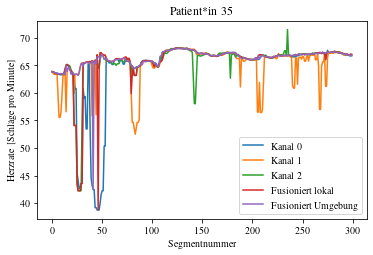

In [8]:
plt.figure(figsize=utils.get_plt_big_size())
for channel in range(3):
    plt.plot(hr_singles[channel, 10000:10300], label="Kanal " + str(channel))
plt.plot(hr_lowest_std[0, 10000:10300], label="Fusioniert lokal")
plt.plot(hr_fusion[0, 10000:10300], label="Fusioniert Umgebung")
plt.title("Patient*in 35")
plt.legend()
plt.xlabel("Segmentnummer")
plt.ylabel("Herzrate [Schläge pro Minute]")
if save:
    plt.savefig(os.path.join(utils.get_thesis_pic_path(),'ecg-patient-35-1.pdf'), transparent=True, bbox_inches='tight', dpi=300)

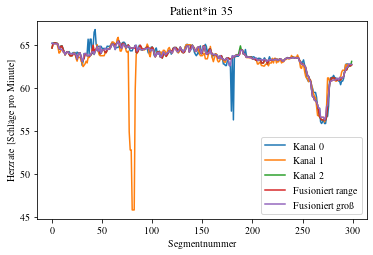

In [9]:
plt.figure(figsize=utils.get_plt_big_size())
for channel in range(3):
    plt.plot(hr_singles[channel, 28000:28300], label="Kanal " + str(channel))
plt.plot(hr_lowest_std[0, 28000:28300], label="Fusioniert range")
plt.plot(hr_fusion[0, 28000:28300], label="Fusioniert groß")
plt.title("Patient*in 35")
plt.xlabel("Segmentnummer")
plt.ylabel("Herzrate [Schläge pro Minute]")
plt.legend()
if save:
    plt.savefig(os.path.join(utils.get_thesis_pic_path(),'ecg-patient-35-2.pdf'), transparent=True, bbox_inches='tight', dpi=300)

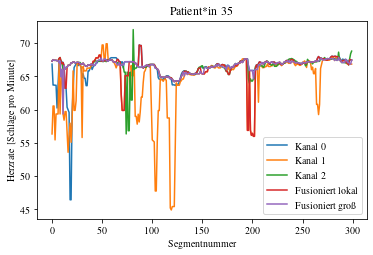

In [10]:
plt.figure(figsize=utils.get_plt_big_size())
for channel in range(3):
    plt.plot(hr_singles[channel, 17000:17300], label="Kanal " + str(channel))
plt.plot(hr_lowest_std[0, 17000:17300], label="Fusioniert lokal")
plt.plot(hr_fusion[0, 17000:17300], label="Fusioniert groß")
plt.xlabel("Segmentnummer")
plt.ylabel("Herzrate [Schläge pro Minute]")
plt.title("Patient*in 35")
plt.legend()
if save:
    plt.savefig(os.path.join(utils.get_thesis_pic_path(),'ecg-patient-35-3.pdf'), transparent=True, bbox_inches='tight', dpi=300)